In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# stdout = sys.stdout
# stderr = sys.stderr
# sys.stdout = open('/dev/null', 'w')
# sys.stderr = open('/dev/null', 'w')
# sys.stderr.close()
# sys.stdout.close()
#sys.stdout=open('./out')
#sys.stderr=stderr

/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# simulated psf function
def makePsf(x, sigma1=1.0, b=0.0, sigma_ratio=2, xc=0):
    I = np.exp(-0.5*((x - xc)/sigma1)**2) + b*np.exp(-0.5*((x - xc)/(sigma_ratio*sigma1))**2)
    I /= np.sum(I)*(x[1] - x[0])
    
    return I

def manyPsf(bList, samples=30):
    X = []
    for b in bList:
        x0 = np.zeros(2*samples + 1)
        x0[0:samples] = np.linspace(-1, 1, samples)
        x0[samples:2*samples] = makePsf(np.linspace(-1,1,samples), b=b)
        x0[-1] = b
        X.append(x0)
    return X

In [11]:
from sklearn.cross_validation import train_test_split
from scipy.special import expit
X = manyPsf(np.linspace(0, 10, 20000))
X = np.vstack(X)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
print X_train[0], expit(X_train[0])

[-1.         -0.93103448 -0.86206897 -0.79310345 -0.72413793 -0.65517241
 -0.5862069  -0.51724138 -0.44827586 -0.37931034 -0.31034483 -0.24137931
 -0.17241379 -0.10344828 -0.03448276  0.03448276  0.10344828  0.17241379
  0.24137931  0.31034483  0.37931034  0.44827586  0.51724138  0.5862069
  0.65517241  0.72413793  0.79310345  0.86206897  0.93103448  1.          0.4358522
  0.44493636  0.45361692  0.46184855  0.46958629  0.47678605  0.48340522
  0.48940327  0.49474232  0.49938772  0.50330864  0.5064785   0.50887551
  0.51048294  0.51128951  0.51128951  0.51048294  0.50887551  0.5064785
  0.50330864  0.49938772  0.49474232  0.48940327  0.48340522  0.47678605
  0.46958629  0.46184855  0.45361692  0.44493636  0.4358522   8.13540677] [ 0.26894142  0.28271489  0.29690726  0.31150269  0.32648243  0.34182489
  0.35750564  0.37349752  0.38977077  0.40629324  0.42303057  0.43994647
  0.45700301  0.47416097  0.49138016  0.50861984  0.52583903  0.54299699
  0.56005353  0.57696943  0.59370676  0.6

This is the trickier part.  We want to train each layer in sequence, and use the weights we get from each layer
to initialize a stacked deep autoencoder.  We can train each layer by using the output hidden representation from the previous autoencoder as input to the next one.  Training the deep autoencoder will use backpropogation to refine the weights in both the encoder and decoder.  Our data each have 61 features, so we will use a 61 - 30 - 15 - 7 - 3 encoder, which means we want to obtain a code of just 3 real numbers.

One thing that I am not sure about is the nonlinearity Hinton uses.  Should I be using a sigmoid/tanh activation function for everything after the first layer when training the encoders?  In that case, I probably should use the same activation function in the stacked encoder/decoder.

I know the code is a little repetitive but I wanted to be explicit about what was going on.

In [12]:
from keras.layers import containers, AutoEncoder, Dense
from keras import models
ACT = 'relu'
INIT = 'glorot_normal'
encoder1 = containers.Sequential()
encoder1.add(Dense(output_dim=30, input_dim=61, init='glorot_uniform', activation='linear'))
decoder1 = containers.Sequential()
decoder1.add(Dense(output_dim=61, input_dim=30, init=INIT, activation=ACT))
ae1 = AutoEncoder(encoder=encoder1, decoder=decoder1, output_reconstruction=True)

encoder2 = containers.Sequential()
encoder2.add(Dense(output_dim=15, input_dim=30, init=INIT, activation=ACT))
decoder2 = containers.Sequential()
decoder2.add(Dense(output_dim=30, input_dim=15, init=INIT, activation=ACT))
ae2 = AutoEncoder(encoder=encoder2, decoder=decoder2, output_reconstruction=True)

encoder3 = containers.Sequential()
encoder3.add(Dense(output_dim=7, input_dim=15, init=INIT, activation=ACT))
decoder3 = containers.Sequential()
decoder3.add(Dense(output_dim=15, input_dim=7, init=INIT, activation=ACT))
ae3 = AutoEncoder(encoder=encoder3, decoder=decoder3, output_reconstruction=True)

encoder4 = containers.Sequential()
encoder4.add(Dense(output_dim=3, input_dim=7, init=INIT, activation=ACT))
decoder4 = containers.Sequential()
decoder4.add(Dense(output_dim=7, input_dim=3, init='glorot_uniform', activation='linear'))
ae4 = AutoEncoder(encoder=encoder4, decoder=decoder4, output_reconstruction=True)

model1 = models.Sequential()
model1.add(ae1)
model2 = models.Sequential()
model2.add(ae2)
model3 = models.Sequential()
model3.add(ae3)
model4 = models.Sequential()
model4.add(ae4)

Now we train each of the autoencoders in sequence.  To get the hidden prediction, we have to disable output reconstruction and then predict X_train.

In [13]:
%%capture
model1.compile(optimizer='sgd', loss='mse')
model1.fit(X_train, X_train, nb_epoch = 100)
ae1.output_reconstruction = False
model1.compile(optimizer='sgd', loss='mse')
h1 = model1.predict(X_train)

model2.compile(optimizer='sgd', loss='mse')
model2.fit(h1, h1, nb_epoch = 100)
ae2.output_reconstruction = False
model2.compile(optimizer='sgd', loss='mse')
h2 = model2.predict(h1)

model3.compile(optimizer='sgd', loss='mse')
model3.fit(h2, h2, nb_epoch = 100)
ae3.output_reconstruction = False
model3.compile(optimizer='sgd', loss='mse')
h3 = model3.predict(h2)

model4.compile(optimizer='sgd', loss='mse')
model4.fit(h3, h3, nb_epoch = 100)
ae4.output_reconstruction = False
model4.compile(optimizer='sgd', loss='mse')
h4 = model4.predict(h3)

Now we can use the weights from each network to initialize a stacked autoencoder with 4 layers on each end

In [14]:
%%capture

W1 = ae1.get_weights()
W2 = ae2.get_weights()
W3 = ae3.get_weights()
W4 = ae4.get_weights()

encoder = containers.Sequential()
encoder.add(Dense(output_dim = 30, input_dim = 61, weights=W1[0:2]))

encoder.add(Dense(output_dim = 15, weights = W2[0:2], activation=ACT))
encoder.add(Dense(output_dim = 7, weights = W3[0:2], activation=ACT))
encoder.add(Dense(output_dim = 3, weights = W4[0:2], activation=ACT))

decoder = containers.Sequential()
decoder.add(Dense(output_dim = 7, input_dim = 3, weights = W4[2:4], activation=ACT))
decoder.add(Dense(output_dim = 15, weights = W3[2:4], activation=ACT))
decoder.add(Dense(output_dim = 30, weights = W2[2:4], activation=ACT))
decoder.add(Dense(output_dim = 61, weights = W1[2:4], activation='linear'))

masterAE = AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=True)
masterModel = models.Sequential()
masterModel.add(masterAE)

masterModel.compile(optimizer='sgd', loss='mse')
masterModel.fit(X_train, X_train, nb_epoch=100)

In [ ]:
representations = masterModel.predict(X_test)

Plot all the representations against the test data.  useful to see if large irregularities are present for everything.

IndexError: index 1000 is out of bounds for axis 0 with size 1000

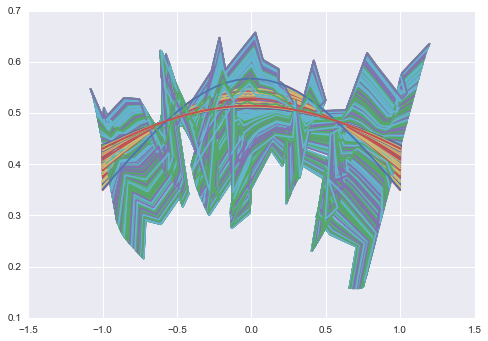

In [15]:
plt.figure()
for i in range(len(X_test)):
    test = plt.plot(X_test[i][0:30], X_test[i][30:60])
    rep = plt.plot(representations[i][0:30], representations[i][30:60])
    
plt.show()

Plot a few representative curves from the validation set.  Green is the representation and blue is the original.

In [ ]:
plt.figure()
for i in range(0, 5):
    val, = plt.plot(X_test[i][0:30], X_test[i][30:60])
    representation, = plt.plot(representations[i][0:30], representations[i][30:60])
    plt.ylabel(r'$I(x,x_c = 0)$', rotation=-1, size=14)
    plt.xlabel(r'$x$', size = 15)
    plt.title('{} Reconstruction (Validation Set)'.format(ACT.title()))
    plt.legend([val, representation], ['validation', 'representation'])
    plt.show()

Plot a few representative curves from the training set.  I'm surprised that this doesn't seem to look any better than the validation set.

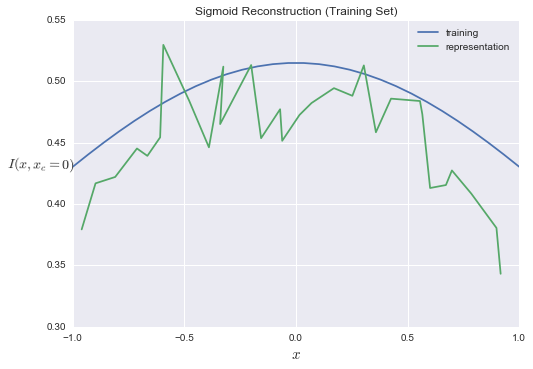

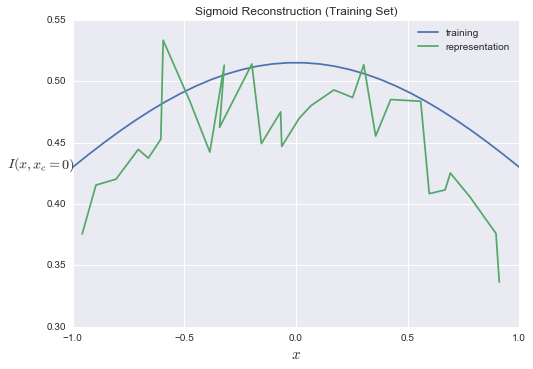

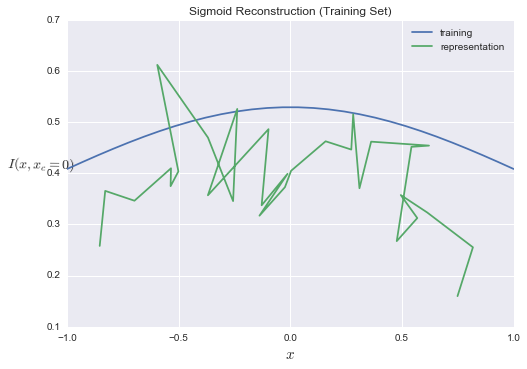

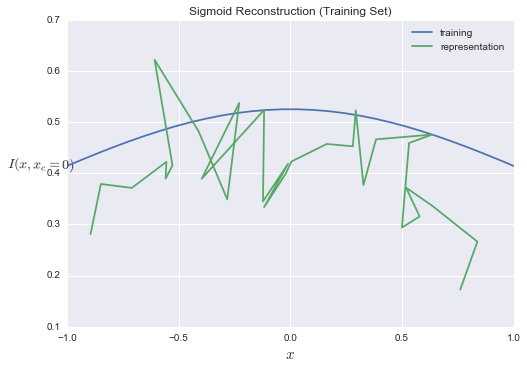

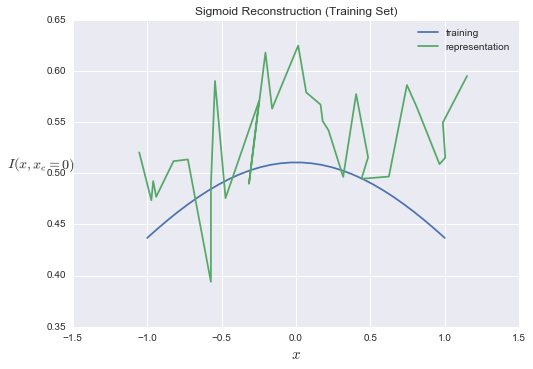

In [10]:
plt.figure()
trainRepresentations = masterModel.predict(X_train)
for i in range(0, 5):
    train, = plt.plot(X_train[i][0:30], X_train[i][30:60])
    representation, = plt.plot(trainRepresentations[i][0:30], trainRepresentations[i][30:60])
    plt.ylabel(r'$I(x,x_c = 0)$', rotation=-1, size=14)
    plt.xlabel(r'$x$', size = 15)
    plt.title('Sigmoid Reconstruction (Training Set)')
    plt.legend([train, representation], ['training', 'representation'])
    plt.show()

Couldn't import dot_parser, loading of dot files will not be possible.


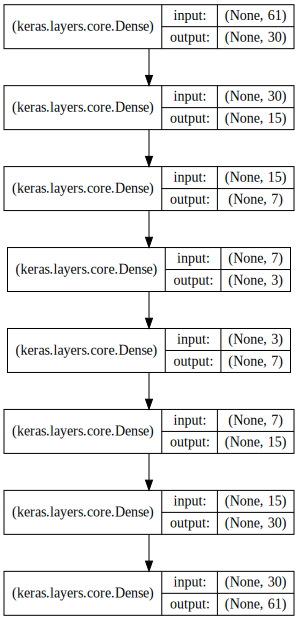

In [31]:
from IPython.display import SVG
from keras.utils.visualize_util import to_graph
SVG(to_graph(encoder, show_shape=True).create(prog='dot', format='svg'))
SVG(to_graph(decoder, show_shape=True).create(prog='dot', format='svg'))
